# Analysis of miRNA hosting genes
This notebook demostrates on how to create cutomized features. The examples is using gencode annotations from the 

In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/home/hsher/Metadensity/config/hg38.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt


# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
%matplotlib inline

Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


## Use some SRSF previously documented to pre-miRNA
let's see if a nested miRNA metagene can show these

In [2]:
all_srsf = []
for index, row in encode_data.loc[encode_data['RBP'].str.contains('SRSF')].iterrows():
    e= eCLIP.from_series(row, single_end = False)
    all_srsf.append(e)


In [3]:
e.read_densities['rep1']

## Create custom  feature on metagene, find miRNA host genes
1. find which transcript host miRNA
2. Build metagene for miRNA-containing transcripts
3. build custom features (miRNA, upstream and downstream regions) into those miRNA
4. extract eCLIP density

In [4]:
from pybedtools import BedTool
miRNA = BedTool('/home/hsher/gencode_coords/gencode.v33.miRNA.gff3')

# miRNA host gene
transcript.intersect(miRNA, s = True, u = True).saveas()

which_transcript = miRNA.intersect(transcript, s = True, wb = True).to_dataframe(header = None)[[0,1,2,3,4,5,6,17]]
which_transcript.columns = ['chrom', 'type', 'feat', 'start', 'end','.', 'strand', 'attr']

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/pybedtools-0.8.1-py3.7-linux-x86_64.egg/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 18 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [5]:
which_transcript.head()

,chrom,type,feat,start,end,.,strand,attr
0,chr1,ENSEMBL,exon,17369,17436,.,-,ID=ENST00000619216.1;Parent=ENSG00000278267.1;...
1,chr1,ENSEMBL,exon,17369,17436,.,-,ID=ENST00000488147.1;Parent=ENSG00000227232.5;...
2,chr1,ENSEMBL,exon,30366,30503,.,+,ID=ENST00000473358.1;Parent=ENSG00000243485.5;...
3,chr1,ENSEMBL,exon,30366,30503,.,+,ID=ENST00000607096.1;Parent=ENSG00000284332.1;...
4,chr1,ENSEMBL,exon,187891,187958,.,-,ID=ENST00000623083.4;Parent=ENSG00000279457.4;...


In [6]:
# extract transcript name
def segment_transcript_name(s):
    return s.split(';')[0].split('=')[1]
which_transcript['transcript_id']= which_transcript['attr'].map(segment_transcript_name)

In [7]:
miRNA_containing_metagene = Build_many_metagene(id_list = which_transcript['transcript_id'].tolist(),
                                                transcript_type = None)

Done building metagene


In [8]:
len(miRNA_containing_metagene)

192

In [9]:
# add feature to those metagene
for transcript_id in miRNA_containing_metagene.keys():
    metagene = miRNA_containing_metagene[transcript_id]
    
    # add feature
    sub = which_transcript.loc[which_transcript['transcript_id']==transcript_id]
    for index, row in sub.iterrows():
        metagene.create_feature(interval = (row['start'], row['end']),
                                feature_name = 'miRNA') # INTERVAL FEATURE
        if metagene.strand == '+':
            # 5'------(start, stop)-----3' (big number)
            metagene.create_feature(interval = (metagene.start, row['start']),
                                   feature_name = 'upstream_miRNA')
            metagene.create_feature(interval = (row['end'], metagene.stop),
                                   feature_name = 'downstream_miRNA')
        else:
            # 3'------(start, stop)-----5'(big number)
            metagene.create_feature(interval = (row['end'], metagene.stop),
                                   feature_name = 'upstream_miRNA')
            metagene.create_feature(interval = (metagene.start, row['start']),
                                   feature_name = 'downstream_miRNA')
    

In [10]:
# remove metagene that has no intronic polya
for transcript_id in list(miRNA_containing_metagene.keys()).copy():
    metagene = miRNA_containing_metagene[transcript_id]
    
    if 'miRNA' not in metagene.featnames:
        del miRNA_containing_metagene[transcript_id]

## extract density from eCLIP

In [11]:
def build_metadensity(eCLIP, metagene = miRNA_containing_metagene):
    ''' build metadensity object for eCLIP and its IDR containing transcript'''
    
    m = Metadensity(eCLIP, eCLIP.name+'_miRNA_nested', metagenes = metagene,
                   background_method = 'relative information', normalize = False)
    m.get_density_array()
    return m

In [12]:
all_meta = [build_metadensity(e) for e in all_srsf]

'Metagene' object has no attribute 'build_full_cds'
'Metagene' object has no attribute 'build_full_cds'
'Metagene' object has no attribute 'build_full_cds'
'Metagene' object has no attribute 'build_full_cds'
'Metagene' object has no attribute 'build_full_cds'


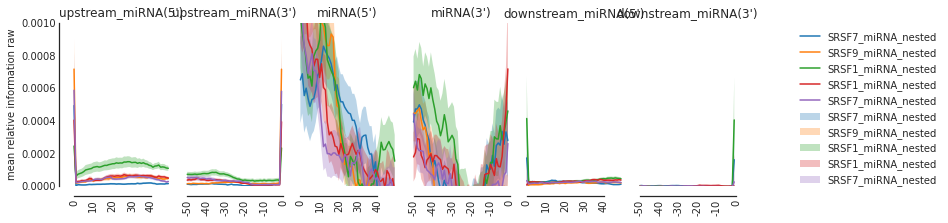

In [13]:
plt.style.use('seaborn-white')
f=plot_mean_density(all_meta,features_to_show = ['upstream_miRNA','miRNA', 'downstream_miRNA'], ymax = 0.001)
f= beautify(f)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity/plotd.py:187: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


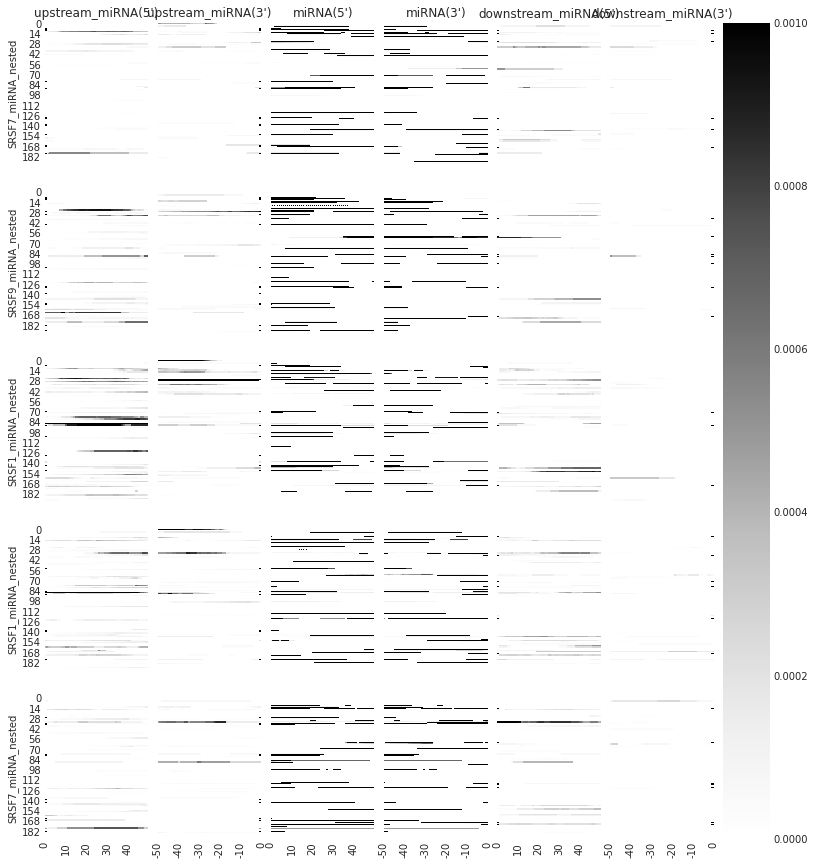

In [14]:
f=plot_rbp_map(all_meta,features_to_show = ['upstream_miRNA','miRNA', 'downstream_miRNA'], ymax = 0.001)